In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from cnn import FontClassifierCNN
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn.utils import clip_grad_norm_
import os
from tqdm import tqdm

c:\Users\weber\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocessing

In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(20),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

# Setup Datasets
train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
validation_dataset = datasets.ImageFolder(root='data/validation', transform=transform)

# Setup DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 522, 1042])


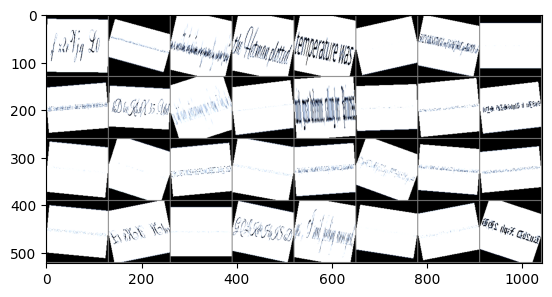

In [3]:
# Validate data loader
def imshow(img):
    print(img.size())
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

### Training Phase

In [4]:
model = FontClassifierCNN(edge=False)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.001)
def train_model(model, train_loader, validation_loader, criterion, optimizer, grad_clip = True, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device in use is: {device}")
    model = model.to(device)
    accuracies = []
    for epoch in tqdm(range(num_epochs)):
        model.train() 
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad() 
            outputs = model(inputs) 
            loss = criterion(outputs, labels) 
            loss.backward() 

            if grad_clip:
                clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step() 
            
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1} Training Loss: {epoch_loss:.4f}')

        # Validation phase
        model.eval()
        validation_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = validation_loss / len(validation_loader.dataset)
        epoch_val_accuracy = 100 * correct / total
        accuracies.append(epoch_val_accuracy)
        print(f'Epoch {epoch+1} Validation Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_accuracy:.2f}%')

    return model,accuracies

# Run the training and validation
num_epochs = 80
model_dir = 'model'
model_gradclip,acc_gradclip = train_model(model, train_loader, validation_loader, criterion, optimizer, grad_clip=True,num_epochs = num_epochs)
model_path = os.path.join(model_dir, 'cnn_grad_clipped.pth')
torch.save(model_gradclip.state_dict(), model_path)


Device in use is: cpu


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1 Training Loss: 2.2790


  1%|▏         | 1/80 [00:46<1:01:49, 46.95s/it]

Epoch 1 Validation Loss: 2.1516, Accuracy: 20.21%
Epoch 2 Training Loss: 1.8242


  2%|▎         | 2/80 [01:18<49:08, 37.80s/it]  

Epoch 2 Validation Loss: 1.5173, Accuracy: 39.54%
Epoch 3 Training Loss: 1.5133


  4%|▍         | 3/80 [01:53<46:44, 36.42s/it]

Epoch 3 Validation Loss: 1.3320, Accuracy: 49.29%
Epoch 4 Training Loss: 1.3517


  5%|▌         | 4/80 [02:41<52:09, 41.17s/it]

Epoch 4 Validation Loss: 1.2967, Accuracy: 47.52%
Epoch 5 Training Loss: 1.2767


  6%|▋         | 5/80 [03:27<53:33, 42.84s/it]

Epoch 5 Validation Loss: 1.3330, Accuracy: 45.04%
Epoch 6 Training Loss: 1.2612


  8%|▊         | 6/80 [04:13<54:24, 44.11s/it]

Epoch 6 Validation Loss: 1.1396, Accuracy: 54.43%
Epoch 7 Training Loss: 1.1577


  9%|▉         | 7/80 [05:03<55:52, 45.93s/it]

Epoch 7 Validation Loss: 1.3624, Accuracy: 45.04%
Epoch 8 Training Loss: 1.0684


 10%|█         | 8/80 [05:52<56:11, 46.82s/it]

Epoch 8 Validation Loss: 1.1392, Accuracy: 51.95%
Epoch 9 Training Loss: 1.0623


 11%|█▏        | 9/80 [06:39<55:30, 46.91s/it]

Epoch 9 Validation Loss: 1.0742, Accuracy: 56.91%
Epoch 10 Training Loss: 0.9905


 12%|█▎        | 10/80 [07:25<54:23, 46.63s/it]

Epoch 10 Validation Loss: 0.9005, Accuracy: 64.72%
Epoch 11 Training Loss: 0.9935


 14%|█▍        | 11/80 [08:11<53:26, 46.47s/it]

Epoch 11 Validation Loss: 0.9562, Accuracy: 61.35%
Epoch 12 Training Loss: 0.9239


 15%|█▌        | 12/80 [08:59<53:15, 46.99s/it]

Epoch 12 Validation Loss: 0.8746, Accuracy: 65.78%
Epoch 13 Training Loss: 0.9482


 16%|█▋        | 13/80 [09:46<52:28, 46.99s/it]

Epoch 13 Validation Loss: 0.8860, Accuracy: 63.48%
Epoch 14 Training Loss: 0.9194


 18%|█▊        | 14/80 [10:37<52:46, 47.98s/it]

Epoch 14 Validation Loss: 1.0457, Accuracy: 62.41%
Epoch 15 Training Loss: 0.9648


 19%|█▉        | 15/80 [11:27<52:44, 48.69s/it]

Epoch 15 Validation Loss: 0.7503, Accuracy: 73.58%
Epoch 16 Training Loss: 0.8806


 20%|██        | 16/80 [12:23<54:21, 50.96s/it]

Epoch 16 Validation Loss: 0.8890, Accuracy: 64.54%
Epoch 17 Training Loss: 0.9005


 21%|██▏       | 17/80 [13:21<55:45, 53.10s/it]

Epoch 17 Validation Loss: 0.8362, Accuracy: 65.96%
Epoch 18 Training Loss: 0.8610


 22%|██▎       | 18/80 [14:14<54:40, 52.91s/it]

Epoch 18 Validation Loss: 0.9502, Accuracy: 61.70%
Epoch 19 Training Loss: 0.8453


 24%|██▍       | 19/80 [15:01<52:04, 51.22s/it]

Epoch 19 Validation Loss: 0.9145, Accuracy: 64.89%
Epoch 20 Training Loss: 0.8315


 25%|██▌       | 20/80 [15:48<50:04, 50.08s/it]

Epoch 20 Validation Loss: 1.0180, Accuracy: 58.33%
Epoch 21 Training Loss: 0.7972


 25%|██▌       | 20/80 [16:37<49:52, 49.88s/it]


KeyboardInterrupt: 

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from cnn import FontClassifierCNN  # Make sure this import matches your file structure
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn.utils import clip_grad_norm_
import os
from tqdm import tqdm

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(20),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the model
model_gradclip = FontClassifierCNN(edge=False)
model_gradclip.load_state_dict(torch.load('model/cnn_grad_clipped.pth'))
model_gradclip.eval()

# Prepare the dataset and DataLoader
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Prepare to track class-wise accuracy
class_correct = list(0. for i in range(len(test_dataset.classes)))
class_total = list(0. for i in range(len(test_dataset.classes)))

# Evaluate the model
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model_gradclip(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Print class-wise accuracy
for i in range(len(test_dataset.classes)):
    if class_total[i] > 0:
        class_accuracy = 100 * class_correct[i] / class_total[i]
        print(f'Accuracy of {test_dataset.classes[i]}: {class_accuracy:.2f}%')
    else:
        print(f'Accuracy of {test_dataset.classes[i]}: N/A - No samples')

# Print overall accuracy
total_correct = sum(class_correct)
total_samples = sum(class_total)
overall_accuracy = 100 * total_correct / total_samples if total_samples > 0 else 0
print(f'Overall accuracy of the model on test data: {overall_accuracy:.2f}%')


Accuracy of AguafinaScript: 100.00%
Accuracy of AlexBrush: 100.00%
Accuracy of Allura: 100.00%
Accuracy of Canterbury: 100.00%
Accuracy of GreatVibes: 91.67%
Accuracy of Holligate Signature: 100.00%
Accuracy of I Love Glitter: 91.67%
Accuracy of James Fajardo: 100.00%
Accuracy of OpenSans: 100.00%
Accuracy of alsscrp: 100.00%
Overall accuracy of the model on test data: 98.41%


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from cnn import FontClassifierCNN  # Make sure this import matches your file structure
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn.utils import clip_grad_norm_
import os
from tqdm import tqdm

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(20),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the model
model_gradclip = FontClassifierCNN(edge=False)
model_gradclip.load_state_dict(torch.load('model/cnn_grad_clipped.pth'))
model_gradclip.eval()

# Prepare the dataset and DataLoader
test_dataset = datasets.ImageFolder(root='sample_eval_data', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Prepare to track class-wise accuracy
class_correct = list(0. for i in range(len(test_dataset.classes)))
class_total = list(0. for i in range(len(test_dataset.classes)))

# Evaluate the model
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model_gradclip(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Print class-wise accuracy
for i in range(len(test_dataset.classes)):
    if class_total[i] > 0:
        class_accuracy = 100 * class_correct[i] / class_total[i]
        print(f'Accuracy of {test_dataset.classes[i]}: {class_accuracy:.2f}%')
    else:
        print(f'Accuracy of {test_dataset.classes[i]}: N/A - No samples')

# Print overall accuracy
total_correct = sum(class_correct)
total_samples = sum(class_total)
overall_accuracy = 100 * total_correct / total_samples if total_samples > 0 else 0
print(f'Overall accuracy of the model on test data: {overall_accuracy:.2f}%')


Accuracy of AguafinaScript: 40.00%
Accuracy of AlexBrush: 20.00%
Accuracy of Allura: 20.00%
Accuracy of Canterbury: 60.00%
Accuracy of GreatVibes: 40.00%
Accuracy of Holligate Signature: 100.00%
Accuracy of I Love Glitter: 20.00%
Accuracy of James Fajardo: 80.00%
Accuracy of OpenSans: 20.00%
Accuracy of alsscrp: 80.00%
Overall accuracy of the model on test data: 48.00%
